#### Import libraries / dataset / split data / encoder

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import time



import warnings


warnings.filterwarnings('ignore')        

c:\Users\Asus\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = 'dataset/new_resampled_whole_data.csv'

df = pd.read_csv(data, header=None ,skiprows=1)
# view dimensions of dataset

df.shape

(4840, 7)

In [4]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


df.columns = col_names

col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [5]:
class_counts=df['class'].value_counts()
print(class_counts)

class
unacc    1210
acc      1210
vgood    1210
good     1210
Name: count, dtype: int64


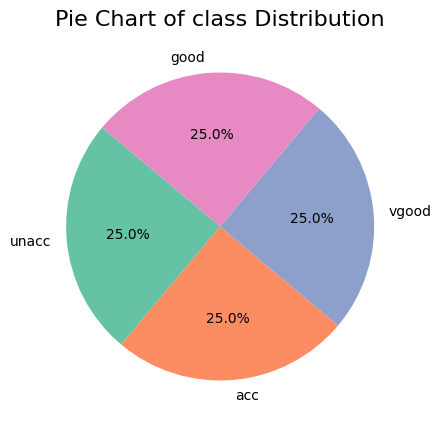

In [6]:
plt.figure(figsize=(7, 5))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
plt.title("Pie Chart of class Distribution", fontsize=16)
plt.show()

In [7]:

X = df.drop(['class'], axis=1)


y = df['class']



# split data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# check the shape of X_train and X_test

X_train.shape, X_test.shape

((3872, 6), (968, 6))

#### Attempt 1: Using Grid Search to find the best parameters for our model

In [8]:
# Parameter Grid
param_options = {
    "criterion": ["gini", "entropy"],  # Function to measure the quality of a split
    "max_features": [1, 6, 'sqrt', 'log2', None],  # Number of features to consider at every split
    "max_depth": [None, 10, 20, 30],  # Maximum number of levels in tree
}

# GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=1000),
    param_grid=param_options,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)  # Fit GridSearchCV to the data
end_time = time.time()
grid_search_time = end_time - start_time



# Results
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

# Print the results
print(f"Grid Search took {grid_search_time:.2f} seconds.")
print("Grid Search Best Parameters:", best_params_grid)
print("Grid Search Best Score:", best_score_grid)



# Compare the best scores from both searches and select the best parameters
best_params = best_params_grid
     

Grid Search took 56.41 seconds.
Grid Search Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 6}
Grid Search Best Score: 0.9845054596982579


#### 1-1 Training Data with default hyperparameters


In [9]:
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)


start_time = time.time()

# fit the model
rfc.fit(X_train, y_train)
# Predict the Test set results
y_pred = rfc.predict(X_test)

end_time = time.time()
rf_best_time = end_time - start_time

# Check accuracy score 

print('Model accuracy score with default hyperparameters : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"training took {rf_best_time:.2f} seconds.")

Model accuracy score with default hyperparameters : 0.9814
training took 0.26 seconds.


#### 1-2 Training Data with custom hyperparameters

In [10]:
rf_best = RandomForestClassifier(**best_params, random_state=0)

start_time = time.time()

# Fit the model to the training data
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

end_time = time.time()
rf_best_time = end_time - start_time

accuracy = accuracy_score(y_test, y_pred)

print("best_params:", best_params)
print(f"Accuracy: {accuracy:.4f}")
print(f"training took {rf_best_time:.2f} seconds.")

best_params: {'criterion': 'gini', 'max_depth': None, 'max_features': 6}
Accuracy: 0.9845
training took 0.25 seconds.


#### Feature Importance

In [11]:
# view the feature scores

feature_scores = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

safety      0.240239
lug_boot    0.219689
maint       0.193530
buying      0.169088
persons     0.153598
doors       0.023855
dtype: float64

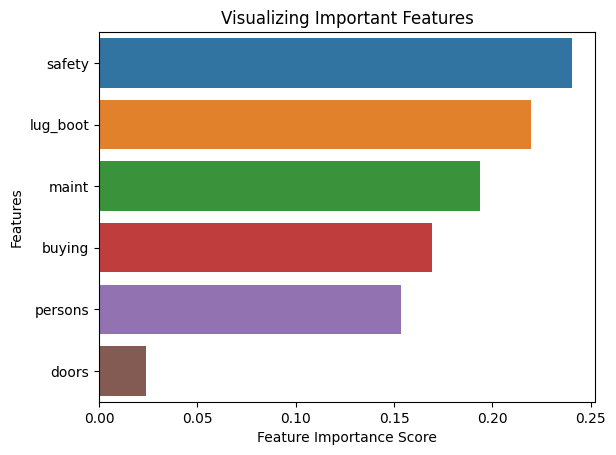

In [12]:
# Creating a seaborn bar plot

sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()

#### Finall Results

In [13]:
# Print the Confusion Matrix and slice it into four pieces


cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[227   7   1   1]
 [  2 224   0   1]
 [  2   1 264   0]
 [  0   0   0 238]]


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.98      0.96      0.97       236
        good       0.97      0.99      0.98       227
       unacc       1.00      0.99      0.99       267
       vgood       0.99      1.00      1.00       238

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



#### Attempt 2: Using custome hyperparameters(disscussed in class of machine learning) for our model

In [1]:
rf_default = RandomForestClassifier(n_estimators = 1000, max_features = 1) # (1, nd)

start_time = time.time()

# Fit the model to the training data
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)

end_time = time.time()
rf_default_time = end_time - start_time

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"training took {rf_default_time:.2f} seconds.")

NameError: name 'RandomForestClassifier' is not defined